# Animal Image Recognition

Ethan Pinto

## Enviroment Setup

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchsummary import summary

import fastai
from fastai.losses import BaseLoss
from fastai.vision.all import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cpu":
    print("WARNING: CUDA is not enabled")
else:
    print("CUDA is enabled")

Set the random seed for reproducibility

In [4]:

SEED = 49

## Pre-process data

Images loaded successfully


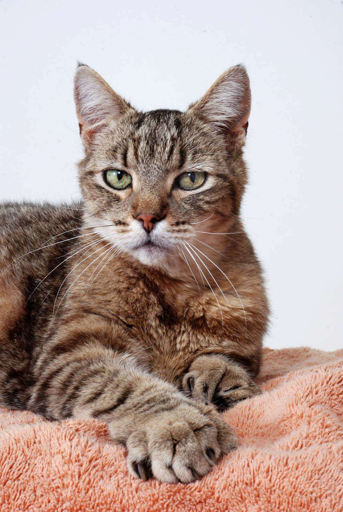

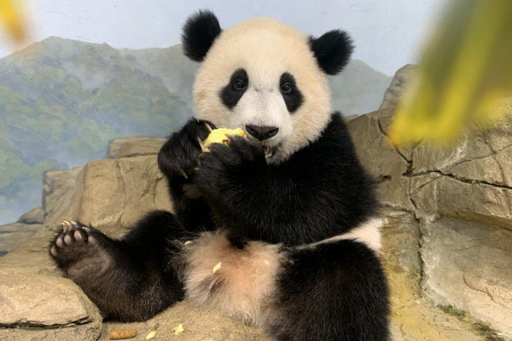

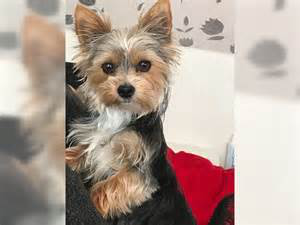

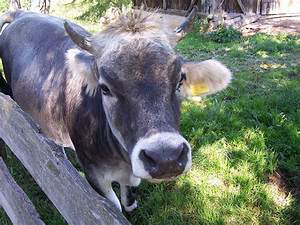

In [5]:
try:
    test_cat = PILImage.create('animals/cat/0b54dde5f5.jpg')
    test_panda = PILImage.create('animals/panda/0d68b6adcb.jpg')
    test_dog = PILImage.create('raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg')
    test_cow = PILImage.create('raw-img/mucca/OIP-_-tg9T0bzHlxyBhXL8Z46AHaFj.jpeg')
    print("Images loaded successfully")
    display(test_cat.to_thumb(512,512))
    display(test_panda.to_thumb(512,512))
    display(test_dog.to_thumb(512,512))
    display(test_cow.to_thumb(512,512))
except FileNotFoundError:
    print("File not found. Please make sure the dataset is downloaded and extracted into correct path")

### Make images the same size so they can be used in a Neural Network.

In [6]:
resize = Resize(128, method='squish')

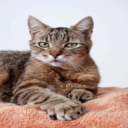

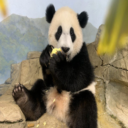

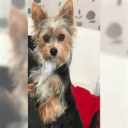

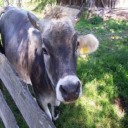

In [7]:
display(resize(test_cat))
display(resize(test_panda))
display(resize(test_dog))
display(resize(test_cow))

### Get the Paths and Labels

In [8]:
def get_paths_and_labels(path):
    paths = get_image_files(path)
    labels = paths.map(parent_label)
    return paths, labels

In [9]:
ANIMAL_90_DIR = Path('animals')
ANIMAL_10_DIR = Path('raw-img')

a_90_paths, a_90_labels = get_paths_and_labels(ANIMAL_90_DIR)
a_10_paths, a_10_labels = get_paths_and_labels(ANIMAL_10_DIR)

print("Length of animal_90_paths: ", len(a_90_paths))
print("Length of animal_90_labels: ", len(a_90_labels))
print("Length of animal_10_paths: ", len(a_10_paths))
print("Length of animal_10_labels: ", len(a_10_labels))

display(a_90_paths[:3])
display(a_90_labels[:3])
display(a_10_paths[:3])
display(a_10_labels[:3])

a_90_paths = np.array(a_90_paths)
a_90_labels = np.array(a_90_labels)
a_10_paths = np.array(a_10_paths)
a_10_labels = np.array(a_10_labels)

Length of animal_90_paths:  5400
Length of animal_90_labels:  5400
Length of animal_10_paths:  26179
Length of animal_10_labels:  26179


(#3) [Path('animals/antelope/02f4b3be2d.jpg'),Path('animals/antelope/03d7fc0888.jpg'),Path('animals/antelope/058fa9a60f.jpg')]

(#3) ['antelope','antelope','antelope']

(#3) [Path('raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg'),Path('raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg'),Path('raw-img/cane/OIP---cByAiEbIxIAleGo9AqOQAAAA.jpeg')]

(#3) ['cane','cane','cane']

### Split Up Paths

Makes sure that animals are split up evenly, especially since there aren't many.

In [10]:
tts = TrainTestSplitter(test_size=0.2, stratify=a_90_labels, random_state=SEED)

In [11]:
train_idx, test_idx = tts(a_90_paths)
train_idx, test_idx

((#4320) [4341,3986,742,4429,2269,1947,528,2401,2611,389...],
 (#1080) [3412,3254,3954,1806,2513,2667,2193,1762,1340,4532...])

In [12]:
train_paths = a_90_paths[train_idx]
test_paths = a_90_paths[test_idx]

### Use DataBlock to Manage Data of "Animal Image Dataset (90 Different Animals)"

In [13]:
def get_dls(paths):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
        splitter=RandomSplitter(seed=SEED),
        get_y=parent_label,
        item_tfms=Resize(128, method='squish'),
    )
    return dblock.dataloaders(paths, bs=128)

In [14]:
train_dls = get_dls(train_paths)

train_dls.train_ds, train_dls.valid_ds

((#3456) [(PILImage mode=RGB size=820x615, TensorCategory(21)),(PILImage mode=RGB size=275x183, TensorCategory(71)),(PILImage mode=RGB size=1024x768, TensorCategory(56)),(PILImage mode=RGB size=259x194, TensorCategory(5)),(PILImage mode=RGB size=515x600, TensorCategory(89)),(PILImage mode=RGB size=910x682, TensorCategory(6)),(PILImage mode=RGB size=640x854, TensorCategory(46)),(PILImage mode=RGB size=1200x632, TensorCategory(19)),(PILImage mode=RGB size=275x183, TensorCategory(48)),(PILImage mode=RGB size=992x558, TensorCategory(85))...],
 (#864) [(PILImage mode=RGB size=1536x1024, TensorCategory(20)),(PILImage mode=RGB size=800x800, TensorCategory(36)),(PILImage mode=RGB size=259x194, TensorCategory(57)),(PILImage mode=RGB size=225x225, TensorCategory(51)),(PILImage mode=RGB size=284x177, TensorCategory(16)),(PILImage mode=RGB size=275x183, TensorCategory(15)),(PILImage mode=RGB size=344x146, TensorCategory(0)),(PILImage mode=RGB size=275x183, TensorCategory(70)),(PILImage mode=RGB si

**NOTE:** Resize will happen when batching happens (It happens lazily).

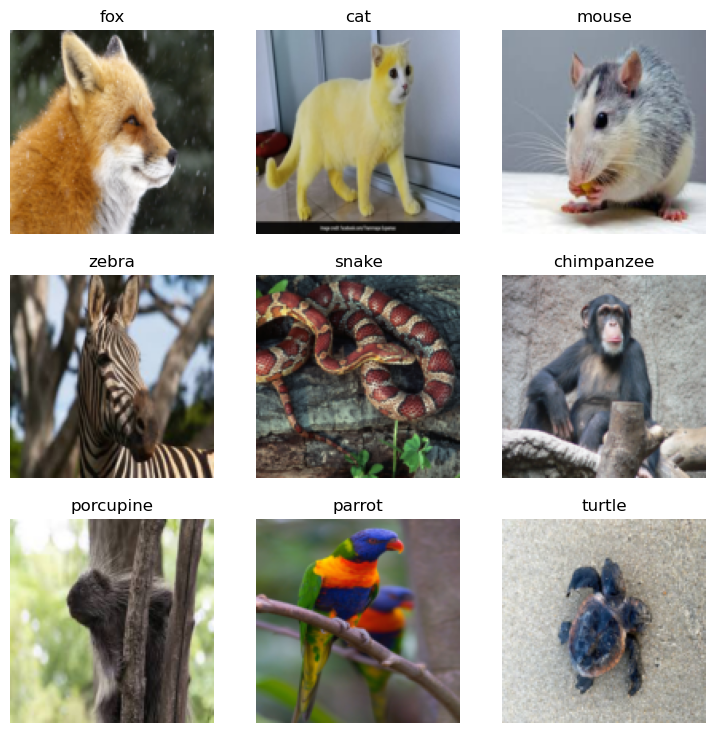

In [15]:
x, y = train_dls.one_batch()
train_dls.show_batch()

## Convolutional Neural Network (CNN)

### Building Layers

In [16]:
def get_cnn_layers():
    return nn.Sequential(
        nn.Conv2d(3, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(64, 128, 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    ).to(device)

cnn_layers = get_cnn_layers()

cnn_out = cnn_layers(x)

cnn_out.shape

torch.Size([128, 128, 14, 14])

In [17]:
def get_fc_layers(unique_labels_len):
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(128*14*14, 128),
        nn.ReLU(),
        nn.Linear(128, unique_labels_len),
        nn.LogSoftmax(dim=1)
    ).to(device)
    
fc_layers = get_fc_layers(90)

fc_out = fc_layers(cnn_out)

fc_out.shape

torch.Size([128, 90])

In [18]:
def get_model(unique_labels_len):
    cnn_layers = get_cnn_layers()
    fc_layers = get_fc_layers(unique_labels_len)
    return nn.Sequential(*cnn_layers, *fc_layers)

model = get_model(90)  # Note: This does recreate the model from scratch

In [19]:
summary(model, x.shape[1:]);

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 126, 126]             896
              ReLU-2         [-1, 32, 126, 126]               0
         MaxPool2d-3           [-1, 32, 63, 63]               0
            Conv2d-4           [-1, 64, 61, 61]          18,496
              ReLU-5           [-1, 64, 61, 61]               0
         MaxPool2d-6           [-1, 64, 30, 30]               0
            Conv2d-7          [-1, 128, 28, 28]          73,856
              ReLU-8          [-1, 128, 28, 28]               0
         MaxPool2d-9          [-1, 128, 14, 14]               0
          Flatten-10                [-1, 25088]               0
           Linear-11                  [-1, 128]       3,211,392
             ReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 90]          11,610
       LogSoftmax-14                   

### Training

In [20]:
def get_learner(dls):
    nll_loss = BaseLoss(nn.NLLLoss)

    nll_loss.decodes = lambda x: x.argmax(axis=1)

    for name, layer in model.named_children():
        if hasattr(layer, 'reset_parameters'):
            # print(name)
            layer.reset_parameters()

    return Learner(dls, model, opt_func=Adam, loss_func=nll_loss, metrics=accuracy)

learn = get_learner(train_dls)

In [21]:
learn.fit(3, .001)

epoch,train_loss,valid_loss,accuracy,time


### Check performance

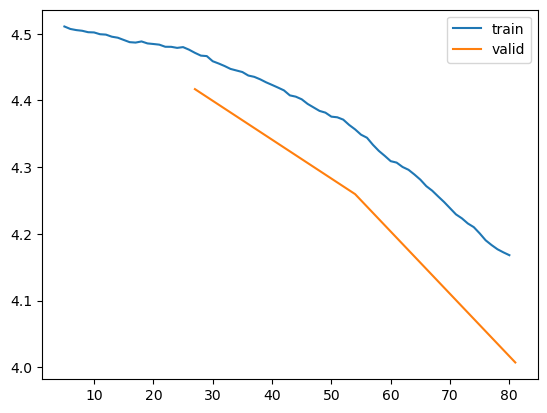

In [22]:
learn.recorder.plot_loss()

In [23]:
test_dl = train_dls.test_dl(test_items=test_paths, with_labels=True)

In [24]:
test_loss, tst_acc = learn.validate(dl=test_dl)

In [25]:
test_logprobs, tst_targets = learn.get_preds(dl=test_dl)

test_preds = test_logprobs.argmax(axis=1)
tst_incorrect_preds = torch.where((tst_targets == test_preds) == False)[0]


print("Test Loss: ", test_loss)
print("Test Accuracy: ", tst_acc)
print("Incorrect Predictions: {}".format(len(tst_incorrect_preds)))

Test Loss:  4.036056041717529
Test Accuracy:  0.07407407462596893
Incorrect Predictions: 1000


## Now do the same thing but with the "Animals-10" dataset

In [26]:
tts = TrainTestSplitter(test_size=0.2, stratify=a_10_labels, random_state=SEED)

In [27]:
train_idx, test_idx = tts(a_10_paths)
train_idx, test_idx

((#20943) [8433,19093,4211,21581,4189,25809,22939,11307,13569,17275...],
 (#5236) [12032,3604,13958,21927,8603,13722,8707,25662,22424,20982...])

In [28]:
train_paths = a_10_paths[train_idx]
test_paths = a_10_paths[test_idx]

In [29]:
train_dls = get_dls(train_paths)

train_dls.train_ds, train_dls.valid_ds

((#16755) [(PILImage mode=RGB size=300x225, TensorCategory(2)),(PILImage mode=RGB size=300x225, TensorCategory(1)),(PILImage mode=RGB size=300x225, TensorCategory(7)),(PILImage mode=RGB size=300x279, TensorCategory(0)),(PILImage mode=RGB size=300x171, TensorCategory(4)),(PILImage mode=RGB size=300x239, TensorCategory(8)),(PILImage mode=RGB size=300x252, TensorCategory(8)),(PILImage mode=RGB size=288x300, TensorCategory(0)),(PILImage mode=RGB size=225x300, TensorCategory(1)),(PILImage mode=RGB size=300x283, TensorCategory(8))...],
 (#4188) [(PILImage mode=RGB size=300x207, TensorCategory(7)),(PILImage mode=RGB size=300x207, TensorCategory(0)),(PILImage mode=RGB size=300x200, TensorCategory(8)),(PILImage mode=RGB size=293x300, TensorCategory(0)),(PILImage mode=RGB size=260x300, TensorCategory(3)),(PILImage mode=RGB size=300x222, TensorCategory(5)),(PILImage mode=RGB size=300x198, TensorCategory(8)),(PILImage mode=RGB size=300x190, TensorCategory(7)),(PILImage mode=RGB size=300x251, Tenso

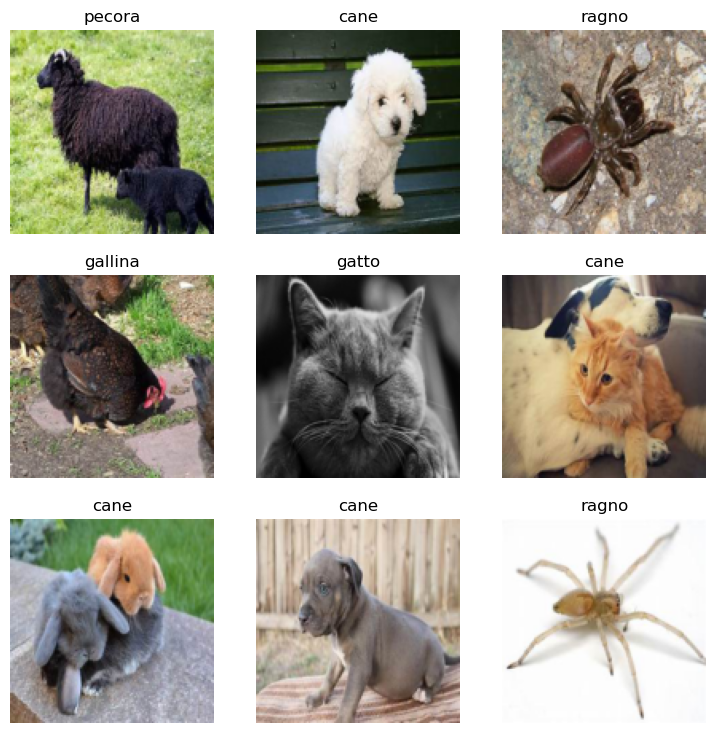

In [30]:
x, y = train_dls.one_batch()
train_dls.show_batch()

In [31]:
model = get_model(10)

In [32]:
learn = get_learner(train_dls)

In [33]:
learn.fit(3, .001)

epoch,train_loss,valid_loss,accuracy,time
0,1.836076,1.725274,0.384193,05:41
1,1.499219,1.473338,0.494986,05:06
2,1.268646,1.316203,0.561127,05:31


### Check performance

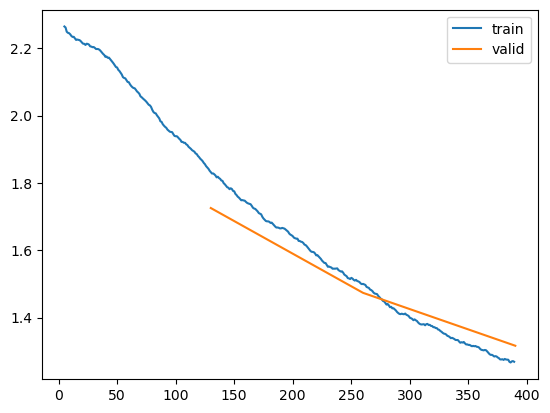

In [34]:
learn.recorder.plot_loss()

In [35]:
test_dl = train_dls.test_dl(test_items=test_paths, with_labels=True)

In [36]:
test_loss, tst_acc = learn.validate(dl=test_dl)

In [37]:
test_logprobs, tst_targets = learn.get_preds(dl=test_dl)

test_preds = test_logprobs.argmax(axis=1)
tst_incorrect_preds = torch.where((tst_targets == test_preds) == False)[0]


print("Test Loss: ", test_loss)
print("Test Accuracy: ", tst_acc)
print("Incorrect Predictions: {}".format(len(tst_incorrect_preds)))

Test Loss:  1.2965775728225708
Test Accuracy:  0.566271960735321
Incorrect Predictions: 2271


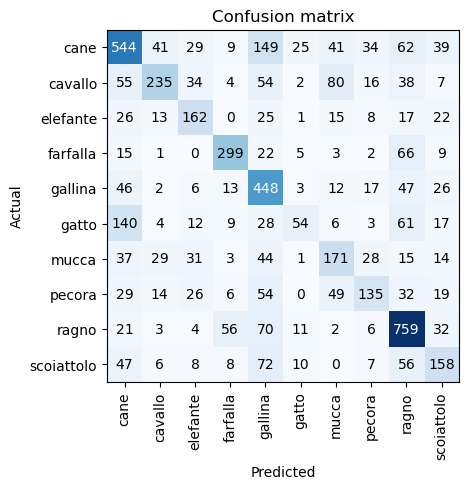

In [38]:
from fastai.vision.all import ClassificationInterpretation

interop = ClassificationInterpretation.from_learner(learn, dl=test_dl)

interop.plot_confusion_matrix()

## Apply PCA

In [39]:
from sklearn.decomposition import PCA

In [86]:
dls = get_dls(a_10_paths)

n_out = len(dls.vocab)

x_train = dls.train.items
y_train = np.array([parent_label(i) for i in dls.train.items])

# dls = DataLoaders.from_dsets(torch.tensor(x_train), torch.tensor(y_train), torch.tensor(x_test), torch.tensor(y_test))

In [87]:
x_train = np.array([PILImage.create(i).resize((128, 128)) for i in x_train])

In [88]:
x_train.shape

(20944, 128, 128, 3)

In [89]:
# convert images to grayscale
x_train_gray = np.mean(x_train, axis=3)

In [90]:
#convert 128x128 to 16384x1
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], -1)

In [91]:
x_train_gray.shape

(20944, 16384)

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_gray = scaler.fit_transform(x_train_gray)

In [47]:
pca = PCA(n_components=0.95, random_state=SEED)

In [48]:
pca.fit(x_train_gray)

PCA(n_components=0.95, random_state=49)

In [49]:
pca.transform(x_train_gray)

array([[ 6.96026612e+01,  5.90322696e+01, -3.10160774e+00, ...,
         7.05500363e-01, -1.76850047e-01,  1.65144576e-01],
       [ 7.84965807e+01, -7.01427458e+01, -3.39663087e+01, ...,
        -6.80900677e-02,  1.46261861e+00,  6.90745571e-01],
       [-5.99822027e+01, -2.76463470e+01, -1.71547199e+01, ...,
        -6.99051672e-01,  3.26212847e-01,  1.07443040e-01],
       ...,
       [ 1.09615782e+02,  1.24595303e+01,  3.18655038e+01, ...,
         3.44762630e-01, -4.85081033e-01, -9.55438498e-01],
       [-1.48129636e+01, -3.94954912e+01,  1.37916603e+01, ...,
        -1.33303258e-02,  5.17962031e-01,  1.65155763e-01],
       [-1.18394073e+02,  9.48660979e+00,  2.77415137e+01, ...,
        -2.58840025e-01, -6.51226377e-01, -3.40832785e-01]])

In [50]:
x_test = test_paths
y_test = np.array([parent_label(i) for i in test_paths])

x_test = np.array([PILImage.create(i).resize((128, 128)) for i in x_test])

x_test_gray = np.mean(x_test, axis=3)

x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], -1)

x_test_gray = StandardScaler().fit_transform(x_test_gray)

x_test_gray = pca.transform(x_test_gray)

In [107]:
n_out

10

In [119]:
cnn_layers = nn.Sequential(
    nn.Conv1d(128, 32, 3),  # Update the number of input channels to 128
    nn.ReLU(),
    nn.MaxPool1d(2),
    nn.Conv1d(32, 64, 3),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),
    nn.Conv1d(64, 128, 3),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2)
).to(device)

fc_layers = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2046, 128),
    nn.ReLU(),
    nn.Linear(128, n_out),
    nn.LogSoftmax(dim=1)
).to(device)

model = nn.Sequential(*cnn_layers, *fc_layers)

In [120]:
nll_loss = BaseLoss(nn.NLLLoss)

nll_loss.decodes = lambda x: x.argmax(axis=1)

for name, layer in model.named_children():
    if hasattr(layer, 'reset_parameters'):
        # print(name)
        layer.reset_parameters()

In [121]:
train_dls = torch.utils.data.DataLoader(x_train_gray, batch_size=128, shuffle=True)

In [122]:
adam = Adam(model.parameters(), lr=0.001)

In [149]:
from sklearn.preprocessing import LabelEncoder
# learn = Learner(train_dls, model, opt_func=Adam, loss_func=nll_loss, metrics=accuracy)

nll_loss = nn.NLLLoss()

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

num_epochs = 3
for _ in range(num_epochs):
    for i, inputs in enumerate(train_dls):
        inputs = inputs.float()

        if inputs.shape[0] != 128:
            continue

        # Forward pass
        outputs = model(inputs)
        
        targets = y_train[i*128:(i+1)*128]

        # Compute loss
        loss = nll_loss(outputs, torch.tensor(targets))
        
        # Backward pass and optimization
        adam.zero_grad()
        loss.backward()
        adam.step()